<a href="https://colab.research.google.com/github/porChe1223/pomodoro_optimization/blob/develop/bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.6 MB/s eta 0:00:00
最適な x: [2.0012256391654066]
最小値: 1.502191363778669e-06


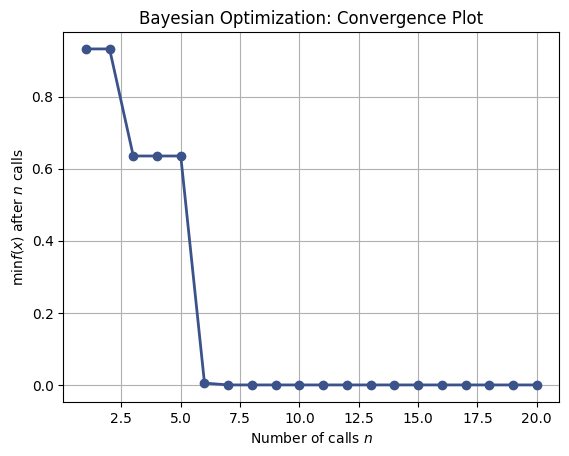

In [ ]:
# 必要なライブラリをインストール
!pip install scikit-optimize

from skopt import gp_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

# 最小化したい関数
def objective(x):
    return (x[0] - 2)**2

# 探索範囲（1次元）
space = [(-5.0, 5.0)]

# ベイズ最適化の実行
result = gp_minimize(
    func=objective,        # 最小化する関数
    dimensions=space,      # 探索空間
    n_calls=20,            # 最大試行回数
    n_initial_points=5,    # 初期ランダム点の数
    random_state=42        # 再現性のため
)

# 最適解
print("最適な x:", result.x)
print("最小値:", result.fun)

# 収束の様子を可視化
plot_convergence(result)
plt.title("Bayesian Optimization: Convergence Plot")
plt.show()


In [ ]:
# 必要なライブラリのインストール
!pip install scikit-optimize pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [16]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.learning import GaussianProcessRegressor
from skopt.callbacks import EarlyStopper
import datetime
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os

#**カーネル関数デフォルト - 初期値だけ25,5でそれ以降から最適化・集中度9.8以上で終了**

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0002
Function value obtained: 8.2302
Current minimum: 8.2302
Iteration No: 2 started. Searching for the next optimal point.

🕒 ポモドーロ設定を提案します:
👉 作業時間: 50.8分
👉 休憩時間: 6.1分
✨ 自動生成された集中度スコア: 6.22
✨ 完了した時間: 2025-04-11 10:49:17.507780
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 0.1646
Function value obtained: -6.2231
Current minimum: -6.2231
Iteration No: 3 started. Searching for the next optimal point.

🕒 ポモドーロ設定を提案します:
👉 作業時間: 50.8分
👉 休憩時間: 6.8分
✨ 自動生成された集中度スコア: 5.48
✨ 完了した時間: 2025-04-11 10:49:17.672147
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 0.4844
Function value obtained: -5.4768
Current minimum: -6.2231
Iteration No: 4 started. Searching for the next optimal point.

🕒 ポモドーロ設定を提案します:
👉 作業時間: 50.9分
👉 休憩時間: 3.0分
✨ 自動生成された集中度スコア: 5.32
✨ 完了した時間: 2025-04-11 10:49:18.156672
Iteration No: 4 en

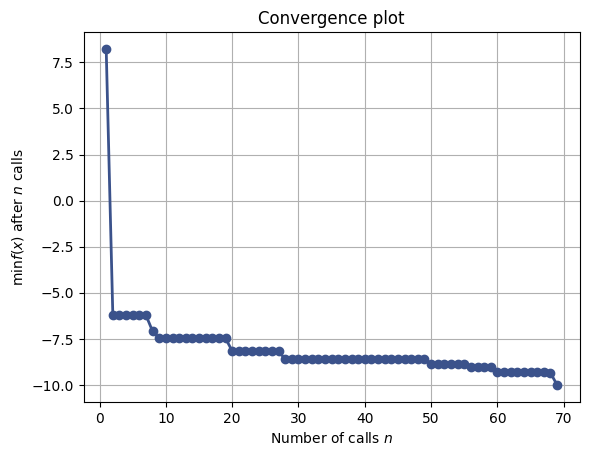

In [18]:
# 🔧 探索空間の定義
space = [
    Real(15, 60, name="work_duration"),    # 作業時間（分）
    Real(3, 20, name="break_duration"),    # 休憩時間（分）
]

# 📦 ログファイルの初期化
log_file = "pomodoro_optimization_log.csv"
if not os.path.exists(log_file):
    pd.DataFrame(columns=["datetime", "work_duration", "break_duration", "focus_score"]).to_csv(log_file, index=False)

def simulate_focus_score(work_duration, break_duration):
    # 理想値との差を取ってスコアを下げる（理想：作業30分、休憩7分）
    work_penalty = abs(work_duration - 30) / 6     # ±6分ずれるごとに1点減点
    break_penalty = abs(break_duration - 7) / 2.5  # ±2.5分ずれるごとに1点減点

    base_score = 10 - (work_penalty + break_penalty)

    # ノイズを追加（±0.5程度のブレ）
    noise = np.random.normal(0, 0.5)
    score = base_score + noise

    # スコアは1〜10にクリップ
    return float(np.clip(score, 1, 10))


# 🧠 最適化する目的関数
@use_named_args(space)
def objective(when=None, **params):
    print(f"\n🕒 ポモドーロ設定を提案します:")
    print(f"👉 作業時間: {params['work_duration']:.1f}分")
    print(f"👉 休憩時間: {params['break_duration']:.1f}分")

    # 🔀 擬似的に集中度をシミュレート
    score = simulate_focus_score(params["work_duration"], params["break_duration"])
    print(f"✨ 自動生成された集中度スコア: {score:.2f}")
    if when is None:
      when = datetime.now()
    print(f"✨ 完了した時間: {when}")

    # ログに保存
    new_entry = {
        "datetime": datetime.now(),
        "work_duration": params["work_duration"],
        "break_duration": params["break_duration"],
        "focus_score": score
    }
    df = pd.read_csv(log_file)
    df = pd.concat([df, pd.DataFrame([new_entry])], ignore_index=True)
    df.to_csv(log_file, index=False)

    return -score

TARGET_SCORE = 9.8

# コールバック関数
def call_back(res):
    current_best = -res.fun
    if current_best >= TARGET_SCORE:
      return True
    return False

initial_point = [25, 5]
initial_score = simulate_focus_score(25, 5)

# 🔁 最適化の実行
result = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=1000,
    n_initial_points=1,
    x0=[initial_point],
    y0=[initial_score],
    random_state=42,
    verbose=True,
    callback=[call_back]
)

# 📊 結果の可視化
print("\n✅ 最適な設定（集中度最大）:")
print(f"作業時間: {result.x[0]:.1f}分")
print(f"休憩時間: {result.x[1]:.1f}分")
print(f"最大集中度: {-result.fun:.1f}")

# 収束プロット
from skopt.plots import plot_convergence
plot_convergence(result)
plt.show()


#**カーネル関数を合成した場合**

Iteration No: 1 started. Evaluating function at random point.

🕒 提案されたポモドーロ設定:
👉 作業時間: 31.9分
👉 休憩時間: 19.2分
✨ 集中度スコア（自動生成）: 4.93
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0060
Function value obtained: -4.9263
Current minimum: -4.9263
Iteration No: 2 started. Evaluating function at random point.

🕒 提案されたポモドーロ設定:
👉 作業時間: 47.9分
👉 休憩時間: 13.2分
✨ 集中度スコア（自動生成）: 4.69
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0039
Function value obtained: -4.6924
Current minimum: -4.9263
Iteration No: 3 started. Evaluating function at random point.

🕒 提案されたポモドーロ設定:
👉 作業時間: 22.0分
👉 休憩時間: 5.7分
✨ 集中度スコア（自動生成）: 8.26
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0038
Function value obtained: -8.2575
Current minimum: -8.2575
Iteration No: 4 started. Evaluating function at random point.

🕒 提案されたポモドーロ設定:
👉 作業時間: 17.6分
👉 休憩時間: 17.7分
✨ 集中度スコア（自動生成）: 4.48
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0039
Function value 

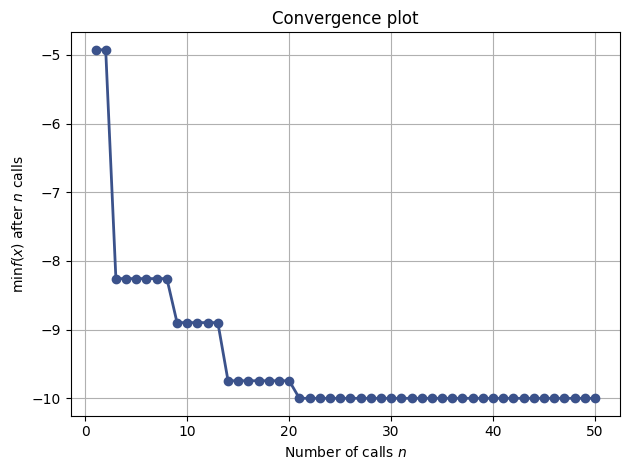

In [ ]:
# 🔧 探索空間の定義
space = [
    Real(15, 60, name="work_duration"),    # 作業時間（分）
    Real(3, 20, name="break_duration"),    # 休憩時間（分）
]

# 📦 ログファイルの初期化
log_file = "pomodoro_optimization_log.csv"
if not os.path.exists(log_file):
    pd.DataFrame(columns=["datetime", "work_duration", "break_duration", "focus_score"]).to_csv(log_file, index=False)

# 🎯 集中度スコアのリアルなモデル（理想からのズレ + ノイズ）
def simulate_focus_score(work_duration, break_duration):
    work_penalty = abs(work_duration - 30) / 6
    break_penalty = abs(break_duration - 7) / 2.5
    base_score = 10 - (work_penalty + break_penalty)
    noise = np.random.normal(0, 0.5)
    return float(np.clip(base_score + noise, 1, 10))

# 🧠 目的関数
@use_named_args(space)
def objective(**params):
    print(f"\n🕒 提案されたポモドーロ設定:")
    print(f"👉 作業時間: {params['work_duration']:.1f}分")
    print(f"👉 休憩時間: {params['break_duration']:.1f}分")
    score = simulate_focus_score(params["work_duration"], params["break_duration"])
    print(f"✨ 集中度スコア（自動生成）: {score:.2f}")

    # ログ保存
    new_entry = {
        "datetime": datetime.datetime.now(),
        "work_duration": params["work_duration"],
        "break_duration": params["break_duration"],
        "focus_score": score
    }
    df = pd.read_csv(log_file)
    df = pd.concat([df, pd.DataFrame([new_entry])], ignore_index=True)
    df.to_csv(log_file, index=False)

    return -score  # スコア最大化 → 最小化問題にするため符号反転

# 🔧 カスタム合成カーネル（滑らか + 粗さ + ノイズ + バイアス）
kernel = (RBF(length_scale=10.0) * Matern(length_scale=5.0, nu=1.5)) + WhiteKernel(noise_level=0.5) + C(1.0)

# 📈 GPRモデルにカスタムカーネルを組み込む
base_estimator = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=42)

# 🔁 ベイズ最適化の実行
from skopt import gp_minimize
result = gp_minimize(
    func=objective,
    dimensions=space,
    base_estimator=base_estimator,
    n_calls=50,
    n_initial_points=5,
    random_state=42,
    acq_optimizer="sampling",
    verbose=True
)

# 📊 最適結果の表示
print("\n✅ 最適なポモドーロ設定:")
print(f"作業時間: {result.x[0]:.1f}分")
print(f"休憩時間: {result.x[1]:.1f}分")
print(f"最大集中度: {-result.fun:.2f}")

# 🔍 収束プロット
from skopt.plots import plot_convergence
plot_convergence(result)
plt.tight_layout()
plt.show()
